# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'
OPT_DIR = 'StyleCLIP'

!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
!git clone https://github.com/khalilacheche/StyleCLIP.git

from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 

In [ ]:
#@title e4e setup
os.chdir(f'./{CODE_DIR}')
from utils.common import tensor2im
from models.psp import pSp
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From: https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:18<00:00, 64.8MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


--2023-05-19 07:27:43--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  27.2MB/s    in 2.2s    

2023-05-19 07:27:46 (27.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


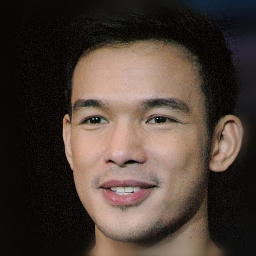

In [ ]:
#@title Align image
image_path = "notebooks/images/input_img.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

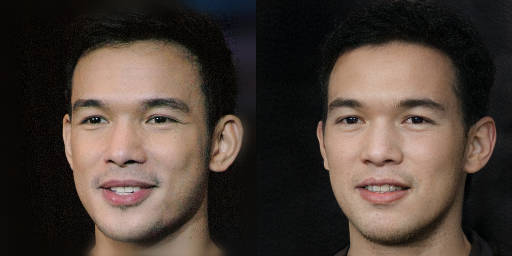

In [ ]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
#This is done in a clone git, so should download the file manually and then upload it.
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

In [ ]:
#@title StyleCLIP Setup

os.chdir(f'/content/{OPT_DIR}')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fqxfcw8q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fqxfcw8q
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=f418e456eb4b83e4ea823df2c0cde672f342644d77760514a87ce7034022df49
  Stored in directory: /tmp/pip-ephem-wheel-cache-przncd80/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

semantic_part = "hair" #@param ["mouth","skin","eyes","nose","ears","eye_brows","hat","hair","neck"]

description = 'A person with blue hair' #@param {type:"string"}

latent_path = "latents.pt" #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

clip_lambda = 1 #@param {type:"number"}

l2_lambda = 0.000 #@param {type:"number"}

loc_lambda = 0.00001 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}

export_segmentation_image = True #@param {type:"boolean"}


In [ ]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

In [ ]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "clip_lambda": clip_lambda,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    "loc_lambda": loc_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth",
    "segmentation_model": "face_segmentation",
    "semantic_part":semantic_part,
    "export_segmentation_image": export_segmentation_image
}

In [ ]:

if use_seed:
  import torch
  torch.manual_seed(seed)
from optimization.run_optimization import main
from argparse import Namespace
result = main(Namespace(**args))

Loading ResNet ArcFace
Loading Segmentation Models


loss: 0.7881, loc_loss: 1940.9536;: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


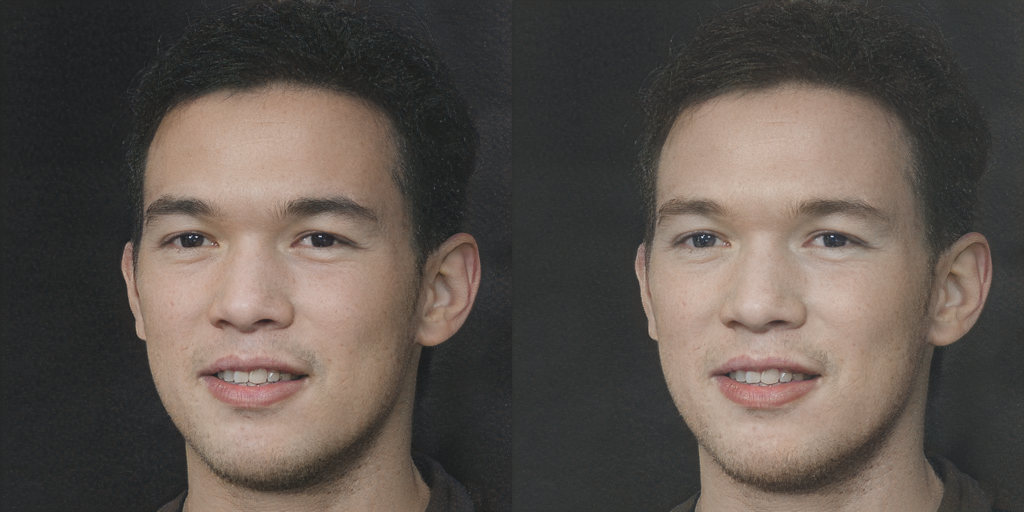

In [ ]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and Download Video

#!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
#from google.colab import files
#files.download('out.mp4')